In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchtext
import tqdm
import copy

from collections import Counter

from flair.data import Sentence
from flair.nn import Classifier
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings
tagger = Classifier.load('sentiment-fast')
glove_embeddings = WordEmbeddings('glove')

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
nltk.download('vader_lexicon')

import gensim
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText

from sklearn.cluster import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import *
from sklearn.feature_extraction import *
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.metrics.pairwise import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/arjunkhanchandani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
mm = MinMaxScaler()

In [3]:
tweets_df = pd.read_csv('/Users/arjunkhanchandani/Desktop/twitter_data_analysis/v2/data/tweets_cleaned_v2.csv')
num_components = 2

print(tweets_df.shape)
tweets_df.head()

(18111, 5)


,tweet_id,tweet,city,year,hashtags
0,0,bad thing say government medical spare operati...,Mumbai,2022,[]
1,1,net family admitted government hospital privat...,Mumbai,2022,[]
2,2,vandi one hotspot measles well respiratory dis...,Mumbai,2022,['#Measles']
3,3,till medical negligence exist government hospi...,Mumbai,2022,[]
4,4,doctor reading also government hospital resident,Mumbai,2022,[]


In [4]:
def creating_tokens(tweets):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(tweets)
    return tokens

tweets_df['tweets_tokens'] = tweets_df.apply(lambda x: creating_tokens(x['tweet']), axis=1)
tweets_df.head()

,tweet_id,tweet,city,year,hashtags,tweets_tokens
0,0,bad thing say government medical spare operati...,Mumbai,2022,[],"[bad, thing, say, government, medical, spare, ..."
1,1,net family admitted government hospital privat...,Mumbai,2022,[],"[net, family, admitted, government, hospital, ..."
2,2,vandi one hotspot measles well respiratory dis...,Mumbai,2022,['#Measles'],"[vandi, one, hotspot, measles, well, respirato..."
3,3,till medical negligence exist government hospi...,Mumbai,2022,[],"[till, medical, negligence, exist, government,..."
4,4,doctor reading also government hospital resident,Mumbai,2022,[],"[doctor, reading, also, government, hospital, ..."


In [5]:
tweets_sentiment_df = tweets_df.copy()
tweets_sentiment_df.head()

,tweet_id,tweet,city,year,hashtags,tweets_tokens
0,0,bad thing say government medical spare operati...,Mumbai,2022,[],"[bad, thing, say, government, medical, spare, ..."
1,1,net family admitted government hospital privat...,Mumbai,2022,[],"[net, family, admitted, government, hospital, ..."
2,2,vandi one hotspot measles well respiratory dis...,Mumbai,2022,['#Measles'],"[vandi, one, hotspot, measles, well, respirato..."
3,3,till medical negligence exist government hospi...,Mumbai,2022,[],"[till, medical, negligence, exist, government,..."
4,4,doctor reading also government hospital resident,Mumbai,2022,[],"[doctor, reading, also, government, hospital, ..."


# Flair Sentiment Analysis

In [6]:
def get_flair_sentiment(tweets):
    sentence = Sentence(tweets)
    tagger.predict(sentence)
    value = sentence.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = 1
    else:
        result = -1
    return result

tweets_sentiment_df['sentiment_flair'] = tweets_sentiment_df.apply(lambda x: get_flair_sentiment(x['tweet']), axis=1)
tweets_sentiment_df.head()

# x = get_flair_sentiment('this is not a movie')
# x

,tweet_id,tweet,city,year,hashtags,tweets_tokens,sentiment_flair
0,0,bad thing say government medical spare operati...,Mumbai,2022,[],"[bad, thing, say, government, medical, spare, ...",-1
1,1,net family admitted government hospital privat...,Mumbai,2022,[],"[net, family, admitted, government, hospital, ...",-1
2,2,vandi one hotspot measles well respiratory dis...,Mumbai,2022,['#Measles'],"[vandi, one, hotspot, measles, well, respirato...",1
3,3,till medical negligence exist government hospi...,Mumbai,2022,[],"[till, medical, negligence, exist, government,...",-1
4,4,doctor reading also government hospital resident,Mumbai,2022,[],"[doctor, reading, also, government, hospital, ...",1


# nltk sentiment

In [7]:
def get_nltk_sentiment(tweet):
    sia  = SentimentIntensityAnalyzer()
    compound = sia.polarity_scores(tweet)['compound']
    if compound >= 0:
        sentiment = 1
    else:
        sentiment = -1
    return sentiment

tweets_sentiment_df['sentiment_nltk'] = tweets_sentiment_df.apply(lambda x: get_nltk_sentiment(x['tweet']), axis=1)
tweets_sentiment_df.head()

,tweet_id,tweet,city,year,hashtags,tweets_tokens,sentiment_flair,sentiment_nltk
0,0,bad thing say government medical spare operati...,Mumbai,2022,[],"[bad, thing, say, government, medical, spare, ...",-1,-1
1,1,net family admitted government hospital privat...,Mumbai,2022,[],"[net, family, admitted, government, hospital, ...",-1,1
2,2,vandi one hotspot measles well respiratory dis...,Mumbai,2022,['#Measles'],"[vandi, one, hotspot, measles, well, respirato...",1,-1
3,3,till medical negligence exist government hospi...,Mumbai,2022,[],"[till, medical, negligence, exist, government,...",-1,-1
4,4,doctor reading also government hospital resident,Mumbai,2022,[],"[doctor, reading, also, government, hospital, ...",1,1


# TFIDF Embeddings

In [8]:
tfidf = TfidfVectorizer()
tfidf_embeddings = tfidf.fit_transform(tweets_sentiment_df['tweet'])
tfidf_embeddings = np.asarray(tfidf_embeddings.todense())
tfidf_embeddings = mm.fit_transform(tfidf_embeddings)

#PCA
tfidf_embeddings_pca = PCA(n_components=num_components).fit_transform(tfidf_embeddings)
tfidf_embeddings_pca.shape

#NMF
nmf = NMF(n_components=num_components)
tfidf_embeddings_nmf = nmf.fit_transform(tfidf_embeddings)

## PCA

### KMeans Clustering

Counter({1: 15380, 0: 2731})
[0 1 0 ... 1 1 1]


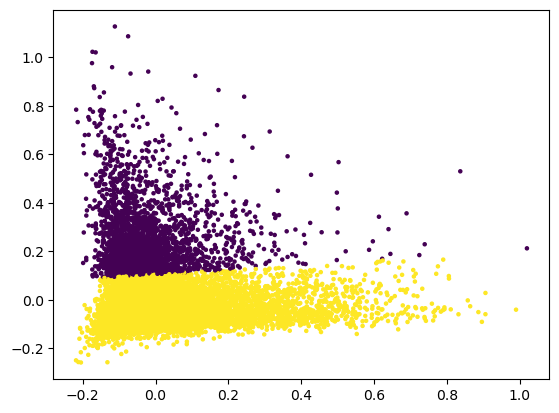

In [9]:
kmeans_tfidf = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=tfidf_embeddings_pca)
positive_cluster_center = kmeans_tfidf.cluster_centers_[0]
negative_cluster_center = kmeans_tfidf.cluster_centers_[1]

tfidf_labels = kmeans_tfidf.predict(tfidf_embeddings_pca)
plt.scatter(tfidf_embeddings_pca[:,0], tfidf_embeddings_pca[:,1], c=kmeans_tfidf.labels_, cmap='viridis', s=5)
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_kmeans_pca'] = tfidf_labels

### Agglomerative Clustering

Counter({0: 16806, 1: 1305})
[0 0 0 ... 0 0 0]
Counter({0: 18054, 1: 57})
[0 0 0 ... 0 0 0]


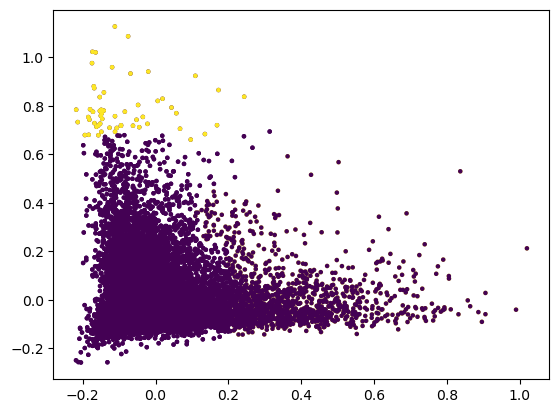

In [10]:
# ward 
agg_ward_tfidf = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_tfidf.fit(X=tfidf_embeddings_pca)
plt.scatter(tfidf_embeddings_pca[:,0], tfidf_embeddings_pca[:,1], c=agg_ward_tfidf.labels_, cmap='viridis', s=5)

tfidf_labels = agg_ward_tfidf.labels_
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_agg_ward_pca'] = tfidf_labels

#complete
agg_complete_tfidf = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_tfidf.fit(X=tfidf_embeddings_pca)
plt.scatter(tfidf_embeddings_pca[:,0], tfidf_embeddings_pca[:,1], c=agg_complete_tfidf.labels_, cmap='viridis', s=5)

tfidf_labels = agg_complete_tfidf.labels_
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_agg_complete_pca'] = tfidf_labels

### Birch Clustering

Counter({0: 16806, 1: 1305})
[0 0 0 ... 0 0 0]


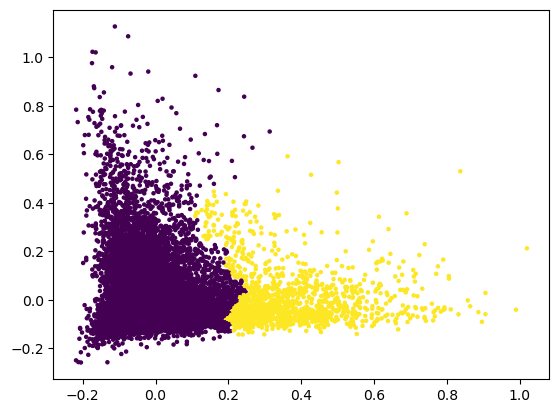

In [11]:
birch_tfidf = Birch(n_clusters=2, threshold=0.000001, branching_factor=5)
birch_tfidf.fit(tfidf_embeddings_pca)
plt.scatter(tfidf_embeddings_pca[:,0], tfidf_embeddings_pca[:,1], c=birch_tfidf.labels_, cmap='viridis', s=5)

tfidf_labels = birch_tfidf.labels_
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_birch_pca'] = tfidf_labels

## NMF Clustering

### KMeans

Counter({0: 15595, 1: 2516})
[1 0 1 ... 0 0 0]


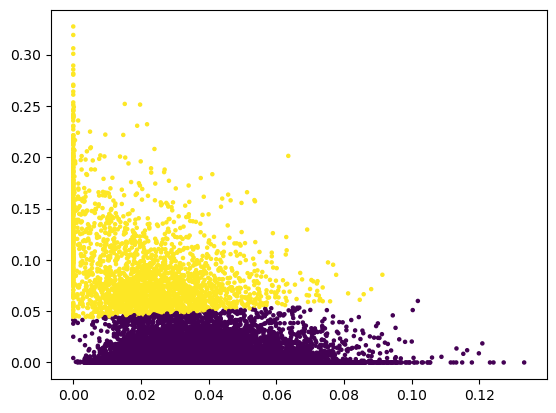

In [12]:
kmeans_tfidf = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=tfidf_embeddings_nmf)
positive_cluster_center = kmeans_tfidf.cluster_centers_[0]
negative_cluster_center = kmeans_tfidf.cluster_centers_[1]

tfidf_labels = kmeans_tfidf.predict(tfidf_embeddings_nmf)
plt.scatter(tfidf_embeddings_nmf[:,0], tfidf_embeddings_nmf[:,1], c=kmeans_tfidf.labels_, cmap='viridis', s=5)
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_kmeans_mnf'] = tfidf_labels

### Agglomerative

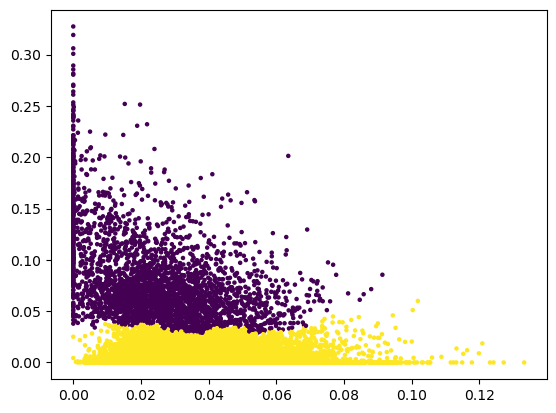

Counter({1: 14974, 0: 3137})
[0 1 0 ... 1 1 1]


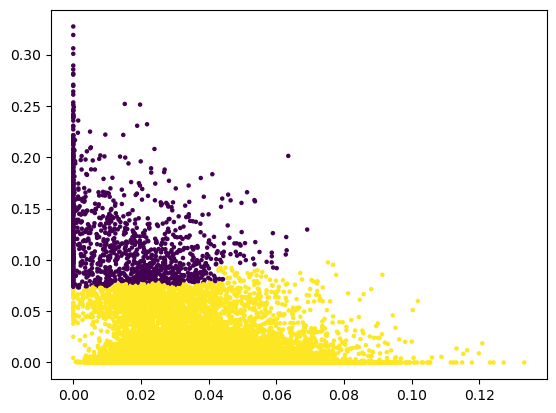

Counter({1: 16898, 0: 1213})
[1 1 0 ... 1 1 1]


In [13]:
# ward 
agg_ward_tfidf = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_tfidf.fit(X=tfidf_embeddings_nmf)
plt.scatter(tfidf_embeddings_nmf[:,0], tfidf_embeddings_nmf[:,1], c=agg_ward_tfidf.labels_, cmap='viridis', s=5)
plt.show()
tfidf_labels = agg_ward_tfidf.labels_
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_agg_ward_nmf'] = tfidf_labels

#complete
agg_complete_tfidf = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_tfidf.fit(X=tfidf_embeddings_nmf)
plt.scatter(tfidf_embeddings_nmf[:,0], tfidf_embeddings_nmf[:,1], c=agg_complete_tfidf.labels_, cmap='viridis', s=5)
plt.show()
tfidf_labels = agg_complete_tfidf.labels_
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_agg_complete_nmf'] = tfidf_labels

### Birch Clustering

Counter({1: 15149, 0: 2962})
[0 1 0 ... 1 1 1]


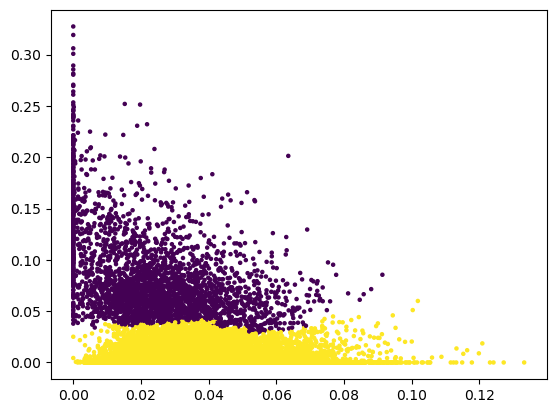

In [14]:
birch_tfidf = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_tfidf.fit(tfidf_embeddings_nmf)
plt.scatter(tfidf_embeddings_nmf[:,0], tfidf_embeddings_nmf[:,1], c=birch_tfidf.labels_, cmap='viridis', s=5)

tfidf_labels = birch_tfidf.labels_
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_birch_nmf'] = tfidf_labels

# FastText Embeddings

In [15]:
embedding_size = 200
window_size = 5
min_word = 2
down_sampling = 1e-2
tokens = tweets_sentiment_df['tweets_tokens']


fast_text_model = FastText(
                        sample=down_sampling,
                        workers = 4,
                        sg=1
                    )

fast_text_model.build_vocab(tokens)
fast_text_model.train(tokens, total_examples=fast_text_model.corpus_count, epochs=fast_text_model.epochs)

fasttext_embeddings = np.array([np.mean([fast_text_model.wv[word] for word in token], axis=0) for token in tokens])
fasttext_embeddings.shape

# fasttext_embeddings = np.asarray(fasttext_embeddings.todense())
fasttext_embeddings = mm.fit_transform(fasttext_embeddings)

#PCA
# fasttext_embeddings = np.asarray(fasttext_embeddings)
fasttext_embeddings_pca = PCA(n_components=num_components).fit_transform(fasttext_embeddings)
print(fasttext_embeddings_pca.shape)

# #NMF
nmf = NMF(n_components=num_components)
fasttext_embeddings_nmf = nmf.fit_transform(fasttext_embeddings)
print(fasttext_embeddings_nmf.shape)

(18111, 2)
(18111, 2)


/Users/arjunkhanchandani/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## PCA

### KMeans

Counter({0: 11098, 1: 7013})
[0 0 0 ... 0 0 1]


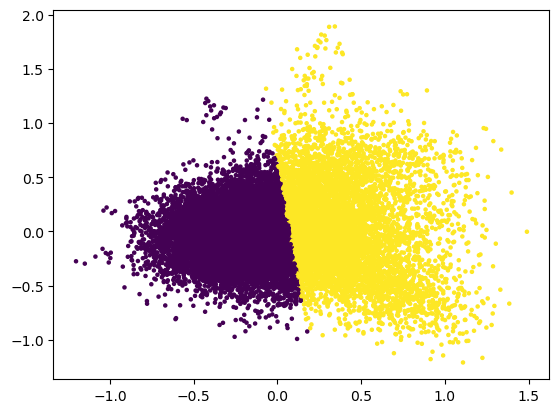

In [16]:
kmeans_fasttext = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=fasttext_embeddings_pca)
positive_cluster_center = kmeans_fasttext.cluster_centers_[0]
negative_cluster_center = kmeans_fasttext.cluster_centers_[1]

fasttext_labels = kmeans_fasttext.predict(fasttext_embeddings_pca)
plt.scatter(fasttext_embeddings_pca[:,0], fasttext_embeddings_pca[:,1], c=kmeans_fasttext.labels_, cmap='viridis', s=5)
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_kmeans_pca'] = fasttext_labels

### Agglomerative Clustering

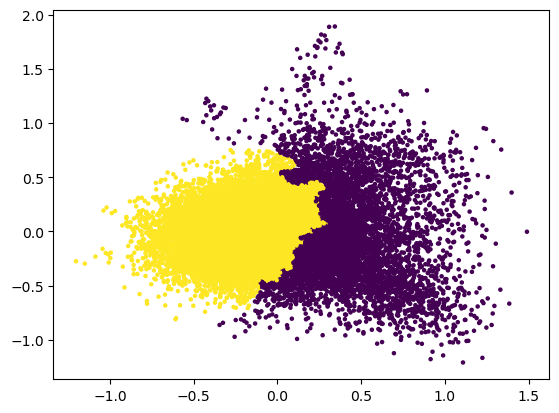

Counter({1: 12165, 0: 5946})
[1 1 1 ... 1 1 0]


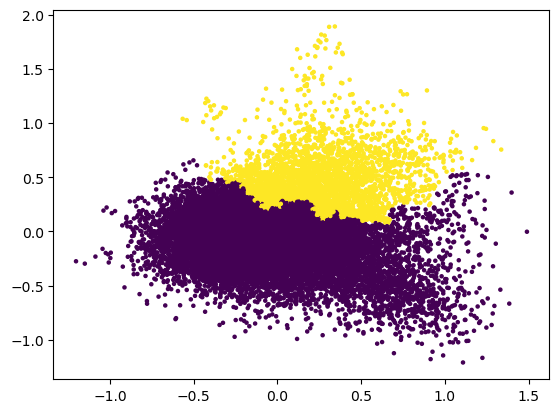

Counter({0: 14846, 1: 3265})
[0 0 0 ... 0 0 0]


In [17]:
# ward 
agg_ward_fasttext = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_fasttext.fit(X=fasttext_embeddings_pca)
fasttext_labels = agg_ward_fasttext.labels_
plt.scatter(fasttext_embeddings_pca[:,0], fasttext_embeddings_pca[:,1], c=agg_ward_fasttext.labels_, cmap='viridis', s=5)
plt.show()
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_agg_ward_pca'] = fasttext_labels

# #complete
agg_complete_fasttext = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_fasttext.fit(X=fasttext_embeddings_pca)
fasttext_labels = agg_complete_fasttext.labels_
plt.scatter(fasttext_embeddings_pca[:,0], fasttext_embeddings_pca[:,1], c=agg_complete_fasttext.labels_, cmap='viridis', s=5)
plt.show()
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_agg_complete_pca'] = fasttext_labels

### Birch Clustering

Counter({0: 10992, 1: 7119})
[0 0 0 ... 0 0 1]


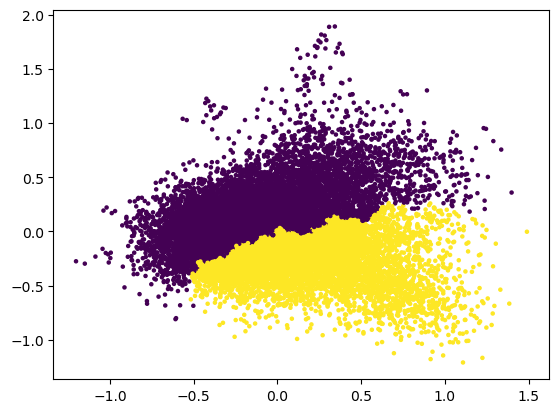

In [18]:
birch_fasttext = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_fasttext.fit(fasttext_embeddings_pca)
plt.scatter(fasttext_embeddings_pca[:,0], fasttext_embeddings_pca[:,1], c=birch_fasttext.labels_, cmap='viridis', s=5)

fasttext_labels = birch_fasttext.labels_
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_birch_pca'] = fasttext_labels

## NMF

### KMeans

Counter({0: 11241, 1: 6870})
[0 0 0 ... 0 0 1]


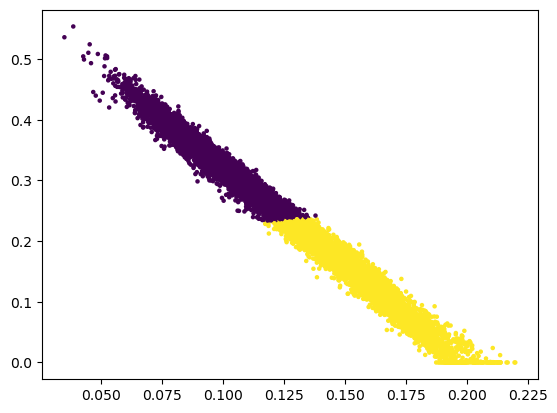

In [19]:
kmeans_fasttext = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=fasttext_embeddings_nmf)
positive_cluster_center = kmeans_fasttext.cluster_centers_[0]
negative_cluster_center = kmeans_fasttext.cluster_centers_[1]

fasttext_labels = kmeans_fasttext.predict(fasttext_embeddings_nmf)
plt.scatter(fasttext_embeddings_nmf[:,0], fasttext_embeddings_nmf[:,1], c=kmeans_fasttext.labels_, cmap='viridis', s=5)
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_kmeans_nmf'] = fasttext_labels

### Agglomerative Clustering

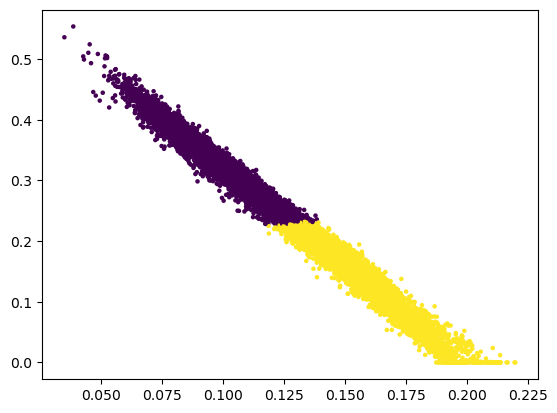

Counter({0: 11599, 1: 6512})
[0 0 0 ... 0 0 1]


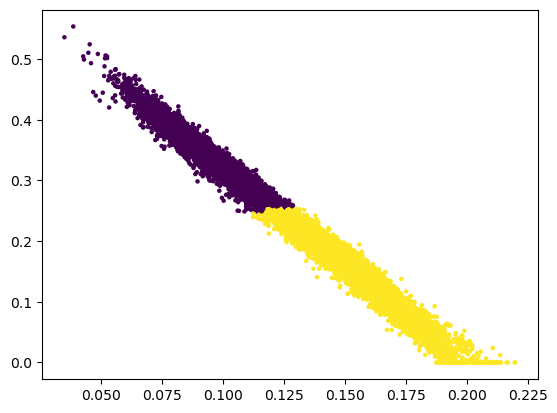

Counter({0: 9819, 1: 8292})
[0 0 0 ... 0 0 1]


In [20]:
# ward 
agg_ward_fasttext = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_fasttext.fit(X=fasttext_embeddings_nmf)
fasttext_labels = agg_ward_fasttext.labels_
plt.scatter(fasttext_embeddings_nmf[:,0], fasttext_embeddings_nmf[:,1], c=agg_ward_fasttext.labels_, cmap='viridis', s=5)
plt.show()
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_agg_ward_nmf'] = fasttext_labels

# #complete
agg_complete_fasttext = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_fasttext.fit(X=fasttext_embeddings_nmf)
fasttext_labels = agg_complete_fasttext.labels_
plt.scatter(fasttext_embeddings_nmf[:,0], fasttext_embeddings_nmf[:,1], c=agg_complete_fasttext.labels_, cmap='viridis', s=5)
plt.show()
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_agg_complete_nmf'] = fasttext_labels

### Birch Clustering

Counter({0: 14790, 1: 3321})
[0 0 0 ... 0 0 1]


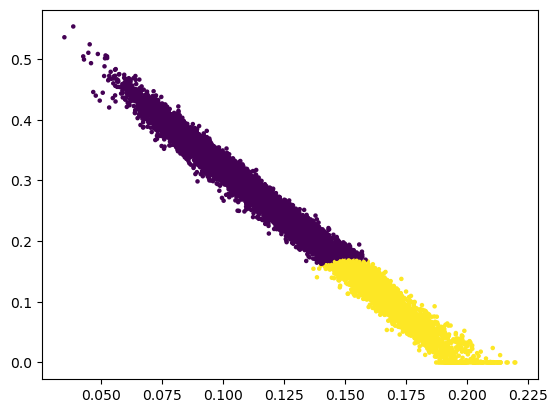

In [21]:
birch_fasttext = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_fasttext.fit(fasttext_embeddings_nmf)
plt.scatter(fasttext_embeddings_nmf[:,0], fasttext_embeddings_nmf[:,1], c=birch_fasttext.labels_, cmap='viridis', s=5)

fasttext_labels = birch_fasttext.labels_
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_birch_nmf'] = fasttext_labels

# Word2Vec Embeddings

In [22]:
tweets_tokens = tweets_sentiment_df['tweets_tokens']

#Detecting Common Phrases so each word is treated as its own
tweets_phrases = gensim.models.phrases.Phrases(tweets_tokens)
tweets_phraser = gensim.models.phrases.Phraser(tweets_phrases)
tweets_phrase = tweets_phraser[tweets_tokens]

MODEL_TRAIN = gensim.models.word2vec.Word2Vec(sentences=tweets_phrase, workers=2)

def word2vec(tokens, model, text_input):
    embeddings = []
    for row in text_input:
        row_vector = np.zeros(model.vector_size)
        for word in row:
            if word in model.wv.index_to_key:
                word_vector = model.wv[word]
                row_vector += word_vector
        embeddings.append(row_vector)
    return np.array(embeddings)

word2vec_embeddings = word2vec(tweets_phrase, MODEL_TRAIN, tweets_phrase)
word2vec_embeddings.shape

word2vec_embeddings = mm.fit_transform(word2vec_embeddings)

#PCA
# word2vec_embeddings = np.asarray(word2vec_embeddings)
word2vec_embeddings_pca = PCA(n_components=num_components).fit_transform(word2vec_embeddings)
print(word2vec_embeddings_pca.shape)

# #NMF
nmf = NMF(n_components=num_components)
word2vec_embeddings_nmf = nmf.fit_transform(word2vec_embeddings)
print(word2vec_embeddings_nmf.shape)

(18111, 2)
(18111, 2)


/Users/arjunkhanchandani/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## PCA

### KMeans

Counter({0: 9763, 1: 8348})
[0 0 0 ... 0 0 1]


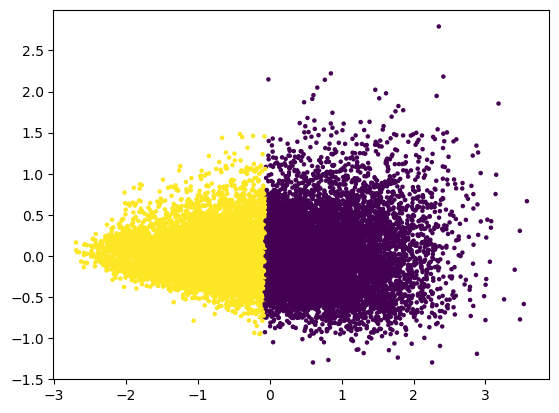

In [23]:
kmeans_word2vec = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=word2vec_embeddings_pca)
positive_cluster_center = kmeans_word2vec.cluster_centers_[0]
negative_cluster_center = kmeans_word2vec.cluster_centers_[1]

word2vec_labels = kmeans_word2vec.predict(word2vec_embeddings_pca)
plt.scatter(word2vec_embeddings_pca[:,0], word2vec_embeddings_pca[:,1], c=kmeans_word2vec.labels_, cmap='viridis', s=5)
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_kmeans_pca'] = word2vec_labels

### Agglomerative Clustering

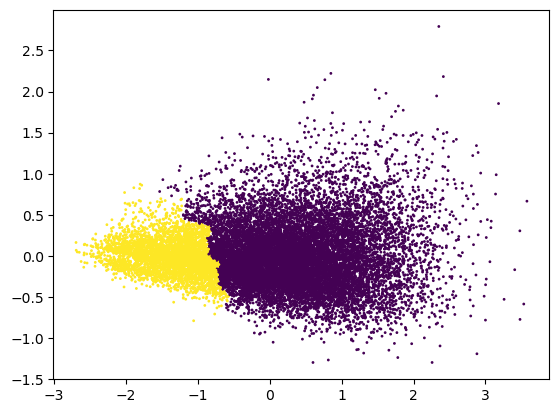

Counter({0: 13983, 1: 4128})
[0 0 0 ... 0 0 1]


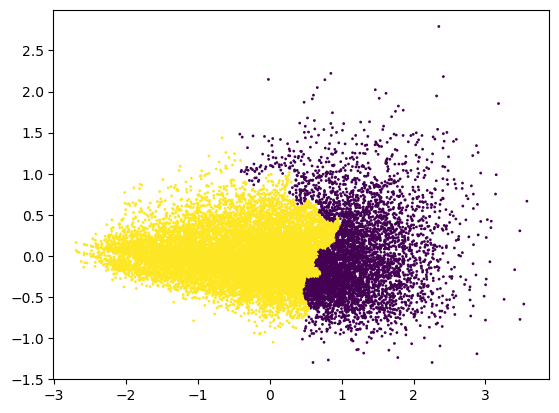

Counter({1: 13090, 0: 5021})
[0 1 0 ... 0 1 1]


In [24]:
# ward 
agg_ward_word2vec = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_word2vec.fit(X=word2vec_embeddings_pca)
word2vec_labels = agg_ward_word2vec.labels_
plt.scatter(word2vec_embeddings_pca[:,0], word2vec_embeddings_pca[:,1], c=agg_ward_word2vec.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_agg_ward_pca'] = word2vec_labels

#complete
agg_complete_word2vec = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_word2vec.fit(X=word2vec_embeddings_pca)
word2vec_labels = agg_complete_word2vec.labels_
plt.scatter(word2vec_embeddings_pca[:,0], word2vec_embeddings_pca[:,1], c=agg_complete_word2vec.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_agg_complete_pca'] = word2vec_labels

### Birch Clustering

Counter({0: 10096, 1: 8015})
[1 1 1 ... 1 0 0]


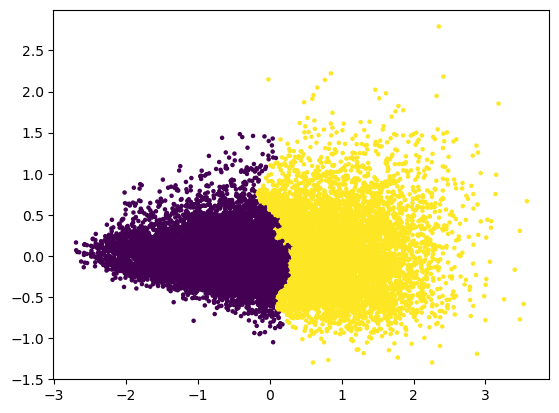

In [25]:
birch_word2vec = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_word2vec.fit(word2vec_embeddings_pca)
plt.scatter(word2vec_embeddings_pca[:,0], word2vec_embeddings_pca[:,1], c=birch_word2vec.labels_, cmap='viridis', s=5)

word2vec_labels = birch_word2vec.labels_
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_birch_pca'] = word2vec_labels

## NMF

### KMeans

Counter({0: 9802, 1: 8309})
[0 0 0 ... 0 0 1]


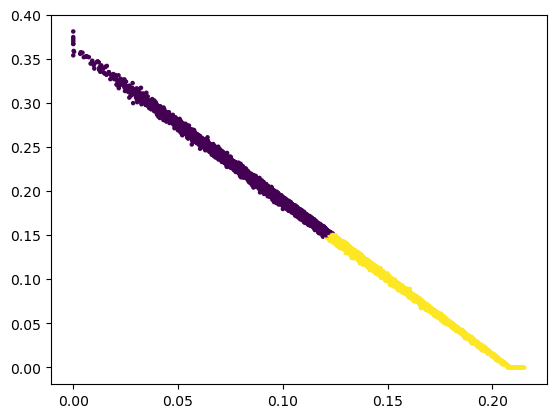

In [26]:
kmeans_word2vec = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=word2vec_embeddings_nmf)
positive_cluster_center = kmeans_word2vec.cluster_centers_[0]
negative_cluster_center = kmeans_word2vec.cluster_centers_[1]

word2vec_labels = kmeans_word2vec.predict(word2vec_embeddings_nmf)
plt.scatter(word2vec_embeddings_nmf[:,0], word2vec_embeddings_nmf[:,1], c=kmeans_word2vec.labels_, cmap='viridis', s=5)
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_kmeans_nmf'] = word2vec_labels

### Agglomerative Clustering

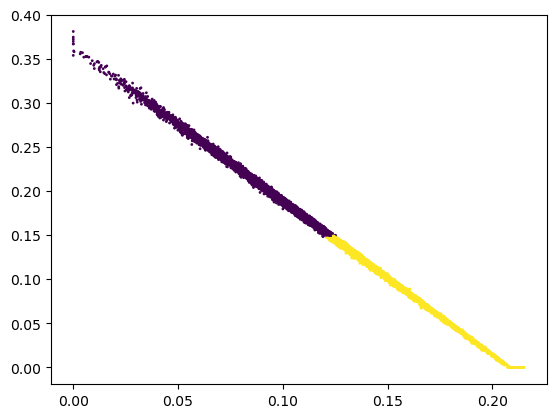

Counter({0: 9879, 1: 8232})
[0 0 0 ... 0 0 1]


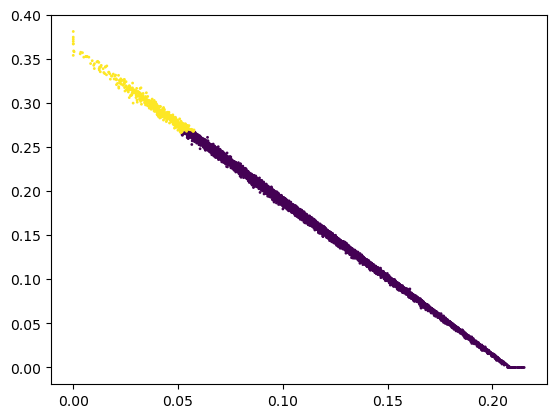

Counter({0: 17378, 1: 733})
[0 0 0 ... 0 0 0]


In [27]:
# ward 
agg_ward_word2vec = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_word2vec.fit(X=word2vec_embeddings_nmf)
word2vec_labels = agg_ward_word2vec.labels_
plt.scatter(word2vec_embeddings_nmf[:,0], word2vec_embeddings_nmf[:,1], c=agg_ward_word2vec.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_agg_ward_nmf'] = word2vec_labels

#complete
agg_complete_word2vec = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_word2vec.fit(X=word2vec_embeddings_nmf)
word2vec_labels = agg_complete_word2vec.labels_
plt.scatter(word2vec_embeddings_nmf[:,0], word2vec_embeddings_nmf[:,1], c=agg_complete_word2vec.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_agg_complete_nmf'] = word2vec_labels

### Birch Clustering

Counter({0: 12766, 1: 5345})
[0 0 0 ... 0 0 1]


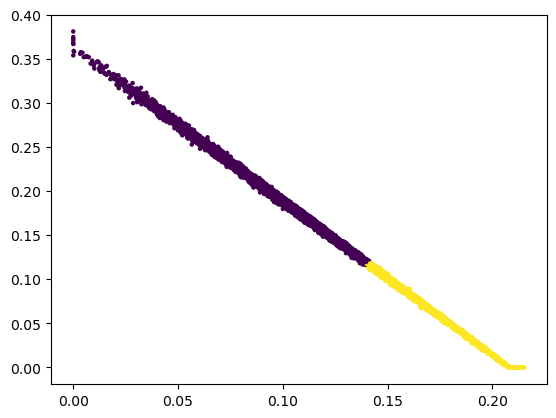

In [28]:
birch_word2vec = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_word2vec.fit(word2vec_embeddings_nmf)
plt.scatter(word2vec_embeddings_nmf[:,0], word2vec_embeddings_nmf[:,1], c=birch_word2vec.labels_, cmap='viridis', s=5)

word2vec_labels = birch_word2vec.labels_
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_birch_nmf'] = word2vec_labels

# Glove Embeddings

In [29]:
glove = torchtext.vocab.GloVe(name="6B", dim=200, max_vectors=10000)
def split_text(text):
    return text.split()

def get_glove_embeddings(glove_vector, x_train_input):
    train = []
    for line in enumerate(x_train_input):
        text = line[-1]
        vector_sum = sum(glove_vector[w] for w in split_text(text))
        label = torch.tensor(int(line[0] == "4")).long()
        train.append((vector_sum, label))
            
    return train

glove_embeddings = get_glove_embeddings(glove, tweets_sentiment_df['tweet'])
glove_embeddings = np.array([x[0].numpy() for x in glove_embeddings])

glove_embeddings = mm.fit_transform(glove_embeddings)

#PCA
glove_embeddings_pca = PCA(n_components=num_components).fit_transform(glove_embeddings)
print(glove_embeddings_pca.shape)

# #NMF
nmf = NMF(n_components=num_components)
glove_embeddings_nmf = nmf.fit_transform(glove_embeddings)
print(glove_embeddings_nmf.shape)

BadZipFile: File is not a zip file

## PCA

### KMeans

In [ ]:
kmeans_glove = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=glove_embeddings_pca)
positive_cluster_center = kmeans_glove.cluster_centers_[0]
negative_cluster_center = kmeans_glove.cluster_centers_[1]

glove_labels = kmeans_glove.predict(glove_embeddings_pca)
plt.scatter(glove_embeddings_pca[:,0], glove_embeddings_pca[:,1], c=kmeans_glove.labels_, cmap='viridis', s=5)
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_kmeans_pca'] = glove_labels

### Agglomerative Clustering

In [ ]:
# ward 
agg_ward_glove = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_glove.fit(X=glove_embeddings_pca)
glove_labels = agg_ward_glove.labels_
plt.scatter(glove_embeddings_pca[:,0], glove_embeddings_pca[:,1], c=agg_ward_glove.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_agg_ward_pca'] = glove_labels

#complete
agg_complete_glove = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_glove.fit(X=glove_embeddings_pca)
glove_labels = agg_complete_glove.labels_
plt.scatter(glove_embeddings_pca[:,0], glove_embeddings_pca[:,1], c=agg_complete_glove.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_agg_complete_pca'] = glove_labels

### Birch Clustering

In [ ]:
birch_glove = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_glove.fit(glove_embeddings_pca)
plt.scatter(glove_embeddings_pca[:,0], glove_embeddings_pca[:,1], c=birch_glove.labels_, cmap='viridis', s=5)

glove_labels = birch_glove.labels_
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_birch_pca'] = glove_labels

## NMF

### KMeans

In [ ]:
kmeans_glove = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=glove_embeddings_nmf)
positive_cluster_center = kmeans_glove.cluster_centers_[0]
negative_cluster_center = kmeans_glove.cluster_centers_[1]

glove_labels = kmeans_glove.predict(glove_embeddings_nmf)
plt.scatter(glove_embeddings_nmf[:,0], glove_embeddings_nmf[:,1], c=kmeans_glove.labels_, cmap='viridis', s=5)
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_kmeans_nmf'] = glove_labels

### Agglomerative Clustering

In [ ]:
# ward 
agg_ward_glove = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_glove.fit(X=glove_embeddings_nmf)
glove_labels = agg_ward_glove.labels_
plt.scatter(glove_embeddings_nmf[:,0], glove_embeddings_nmf[:,1], c=agg_ward_glove.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_agg_ward_nmf'] = glove_labels

#complete
agg_complete_glove = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_glove.fit(X=glove_embeddings_nmf)
glove_labels = agg_complete_glove.labels_
plt.scatter(glove_embeddings_nmf[:,0], glove_embeddings_nmf[:,1], c=agg_complete_glove.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_agg_complete_nmf'] = glove_labels

### Birch Clustering

In [ ]:
birch_glove = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_glove.fit(glove_embeddings_nmf)
plt.scatter(glove_embeddings_nmf[:,0], glove_embeddings_nmf[:,1], c=birch_glove.labels_, cmap='viridis', s=5)

glove_labels = birch_glove.labels_
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_birch_nmf'] = glove_labels

# Value Counts

In [ ]:
print(tweets_sentiment_df.sentiment_flair.value_counts())
print(tweets_sentiment_df.sentiment_nltk.value_counts())
print(tweets_sentiment_df.sentiment_flair_glove_embed_kmeans.value_counts())
# print(tweets_sentiment_df.sentiment_flair_document_embed_kmeans.value_counts())
print(tweets_sentiment_df.sentiment_fast_text_embed_kmeans.value_counts())
print(tweets_sentiment_df.sentiment_fast_text_embed_nmf_kmeans.value_counts())

In [ ]:
pd.DataFrame.to_csv(tweets_sentiment_df, '/Users/arjunkhanchandani/Desktop/twitter_data_analysis-main/v2/data/tweets_with_sentiment__version_2_1.csv', index=False)

In [ ]:
# https://pub.towardsai.net/sentiment-analysis-without-modeling-textblob-vs-vader-vs-flair-657b7af855f4